<h1 class="text-center">Méthodes de Monte-Carlo</h1>

In [1]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3


<a id="SIMUSTO"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> III. Eléments de simulation stochastique et méthode du rejet</h1>


<div class="alert alert-success"> On présente ici des éléments de simulation stochastique. On discute d'abord de méthodes pour vérifier qu'une variable aléatoire suit une loi donnée, puis on présente la méthode du rejet, qui permet de générer une variable aléatoire avec une loi donnée. Une autre méthode classique et très importante est la méthode d'inversion de la fonction de répartition qui fait l'objet du DM.<br>
<br>
Nous verrons dans la suite du cours que la méthode du rejet est à la base de la technique d'échantillonnage préférentiel et des méthodes de Monte-Carlo à base de chaînes de Markov.<br>
<br>
<b>Rappel</b>. La fonction de répartition d'une variable aléatoire $X$, notée $F_X$, est la fonction $F_X(x) = P(X \leq x)$.
</div>



<h2> III.1. Histogramme et densité </h2>

Soit $X$ une variable aléatoire absolument continue que l'on sait générer mais dont on ne connaît pas la densité. Pour vérifier qu'une densité candidate $g$ est proche de la véritable densité, une manière très visuelle est de générer un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ et de comparer un histogramme associé à cet échantillon à $g$.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.1.<b> Soit $(Y_k)$ i.i.d. qui suivent une loi exponentielle de paramètre $1/2$. Le théorème central limite prédit que
$$ X = \sum_{k=1}^{100} Y_k $$
suit approximativement une loi normale : quels sont les paramètres de cette loi ?</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.1.<b> 

Si $Y_k$ sont i.i.d, alors le Théorème Central Limite nous dit:

$$lim_{N \to \infty} \frac{\sum_{k=1}^N (Y_k - \mu)}{\sqrt{N \sigma^2}} \mathop{\sim} N(0,1) \Leftrightarrow  lim_{N \to \infty} {\sum_{k=1}^N Y_k} \mathop{\sim} N(N\mu,N\sigma^2)$$

Ici, $Y_k$ i.i.d. qui suivent une loi exponentielle de paramètre $1/2$, ce parametre étant $\beta = 1/\lambda$, qui est l'ésperance. Donc, $\mu=(1/2)$, $\sigma^2 = (1/2)^2=(1/4)$, et pour N=100 on obtient: $$ {\sum_{k=1}^{100} Y_k} \mathop{\sim} N(50,25)$$
</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.2.</b> Vérifiez votre réponse en complétant le script suivant, et commentez les résultats obtenus.</p>

C:\Users\migue\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


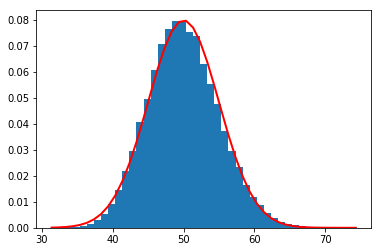

In [2]:
taille_echantillon = 10**5
nb_termes = 100
parametre_exp = .5
exp_values = np.random.exponential(parametre_exp, (taille_echantillon, nb_termes))
echantillon = np.zeros(taille_echantillon)
for i in range(taille_echantillon):
    echantillon[i] = np.sum(exp_values[i,:])
count, bins, ignored = plt.hist(echantillon, np.arange(np.min(echantillon)-0.5, np.max(echantillon)+1.5), normed=True)
mu = parametre_exp * nb_termes
sigma = (nb_termes**0.5) * parametre_exp
plt.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.2.</b> 

Traçant l'histogramme à partir de l'échantillon obtenu et la fonction densité de probabilité théorique de la distribuition normal de paramètres $\mu=50$ et $\sigma=25$, on trouve effectivement que l'histogramme expérimental de X suit approximativement l'histogramme théorique, comme prévu par le Théorème Central Limite
</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.1.3.</b> Discutez des limitations potentielles de cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.1.3.</b> 

Tout d'abbord, on compare une courbe théorique qui est continue avec un histogramme à paliers discrets, la comparaison étant ainsi limitée à une certaine précision à cause de la différence entre les domaines discrets et continus. Par exemple, on ne peut pas obtenir la valeur 50.5 à partir de la somme, mais avec la courbe continue on pourrait obtenir cette valeur.

En outre, pour obtenir un histogramme le meilleur possible, la taille d'échantillon devrait augmenté autant que possible. En effet, si elle n'est pas suffisament grande, une de deux situations pourrait se passer pour des valeurs loin de $\mu$. D'un cotê, on n'obtient jamais une somme de cette valeur et on dit que la probabilité de l'obtenir est nulle, ce qui n'est pas vrai, mais dû au fait qu'on a une taille d'échantillonage petite et donc on a jamais tiré cette valeur. D'autre cotê, on obtient ces valeurs mais comme la taille d'échantillonage est petite on va arriver à la conclusion que la probabilité de les obtenir est plus élevée qu'en realité. En principe, on peut espérer que la précision soit plus élevée au milieu et se dégrade vers les bouts.

Donc, il faut une taille d'échantillonage suffisament grande pour obtenir des histogrammes fiables. Cependant, il y a aussi le problème de comparer des valeurs discrètes et continues. Pour cela, il faudrait jouer avec la taille des paliers. Si on somme 200 valeurs et divise par deux, on réussi déjà à obtenir des paliers de taille 0.5 au lieu de taille 1.

</div>

<h2> III.2. Fonction de répartition empirique </h2>

Nous présentons maintenant une méthode plus rigoureuse. On considère un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ à valeurs dans $\mathbb{R}$ et on s'intéresse à la fonction
$$ \widehat F_N: x \in \mathbb{R} \mapsto \frac{1}{N} \sum_{k=1}^N {\bf 1}(X_k \leq x). $$


<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.1.</b> Montrez que $\widehat F_N(x) \to F_X(x)$ pour tout $x \in \mathbb{R}$ fixé.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.1.</b> 
Comme $X_k$ sont i.i.d
$$ E[\widehat F_N] = E[\frac{1}{N} \sum_{k=1}^N {\mathbb{1}}(X_k \leq x)] = \frac{1}{N} \sum_{k=1}^N {E[\mathbb{1}}(X_k \leq x)] = \frac{1}{N} N E[\mathbb{1}(X_1 \leq x)] = E[\mathbb{1}(X_1 \leq x)] = P(X_1 \leq x) = F_X(x)$$
    
Alors, comme d'après le Theorème Central Limite, la variance diminue quand N augmente et tend vers 0 quand $N \to \infty$, $$lim_{N \to \infty} \widehat F_N(x) = F_X(x) $$

</div>

La fonction $\widehat F_N$ es appelée **fonction de répartition empirique** de $X$. Pour vérifier qu'une variable aléatoire suit une loi de fonction de répartition $F$, on peut donc superposer $\widehat F_N$ et $F$ et accepter que $F = F_X$ si les deux courbes sont proches pour $n$ suffisamment grand.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.2.</b> Complétez le script suivant pour vérifier que les fonctions <code>stats.uniform.rvs</code>, <code>stats.expon.rvs</code>, <code>stats.poisson.rvs</code> et <code>stats.gamma.rvs</code> renvoient bien des variables aléatoires qui suivent la loi uniforme, la loi exponentielle, la loi de Poisson et la loi gamma, respectivement. Utilisez pour cela la fonction <code>ecdf</code>. A partir de quelle taille d'échantillon les approximations vous semblent-elles valides ?</p>

In [3]:
def ecdf(echantillon):
    """
    Cette fonction prend en entrée un échantillon
    et renvoie le couple (sorted_, yvals) qui est tel que
    np.step(sorted_, yvals) trace la fonction de répartition empirique
    """
    sorted_ = np.sort(echantillon)
    yvals = np.arange(len(sorted_))/float(len(sorted_))
    sorted_ = np.append(sorted_, np.amax(echantillon))
    sorted_ = np.append(sorted_, np.amax(echantillon)+1)
    sorted_ = np.insert(sorted_, 0, np.amin(echantillon)-1)
    yvals = np.append(yvals, 1)
    yvals = np.append(yvals, 1)
    yvals = np.insert(yvals, 0, 0)
    return (sorted_, yvals)

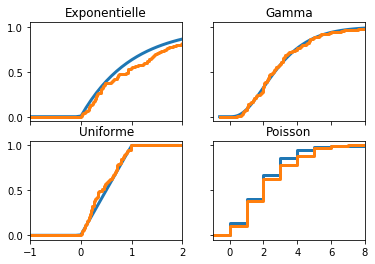

In [4]:
taille = 10**2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0: # exponentielle
        echantillon = stats.expon.rvs(size = taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax1
        a.plot(x, stats.expon.cdf(x))
    if i==1: # gamma
        echantillon = stats.gamma.rvs(a=3, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, a=3))
    if i==2: # uniforme
        echantillon = stats.uniform.rvs(size = taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x))
    if i==3: # poisson
        echantillon = stats.poisson.rvs(mu=2, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x, mu=2))
    s, y = ecdf(echantillon)
    a.step(s, y)
    a.set_title(t[i])
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.2.</b> 

On voit que les fonctions de distribuition empiriques s'approchent des valeurs théoriques en augmentant la taille de l'échantillon, mais la taille d'échantillon à partir de laquelle les approximations sont valides dépend de la précision qu'on souhaite atteindre. Pour la taille proposée (100), même si c'est vrai qu'il y a quelques écarts visibles entre les courbes théoriques et expérimentales, l'allure des courbes est assez bonne et donc 100 me semble une taille raisonable si on ne veut pas l'augmenter trop.

</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.2.3.</b> Soient $U_1$, $U_2$ indépendantes et uniformément réparties sur $[0,1]$ et $Z = \sqrt{- 2 \ln U_1} \cos(2 \pi U_2)$. Vous pouvez générer au plus 200 variables aléatoires. Parmi les choix suivants, quelle est selon vous la loi de $Z$?
<br>

&#9679; Cauchy, i.e., $f_Z(z) \propto 1/(1+z^2)$ (cf. ``stats.cauchy``)

<br>

&#9679; Laplace, i.e., $f_Z(z) \propto e^{-\lvert z \rvert}$ (cf. ``stats.laplace``)

<br>

&#9679; Gauss, i.e., $f_Z(z) \propto e^{-z^2/2}$ (cf. ``stats.norm``)</p>

Text(0.5, 0.98, 'Détermination de la loi de Z')

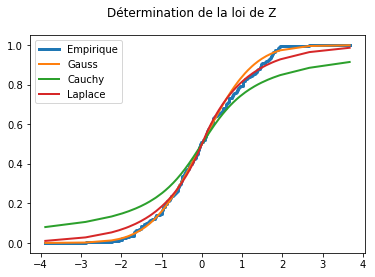

In [5]:
taille_echantillon = 200
u = stats.uniform.rvs(size=(2, taille_echantillon))
z = np.sqrt((-2) * np.log(u[0])) * np.cos(2*np.pi*u[1])
s,y = ecdf(z)
plt.step(s,y, label="Empirique")
plt.plot(s, stats.norm.cdf(s), linewidth=2, label="Gauss")
plt.plot(s, stats.cauchy.cdf(s), linewidth=2, label="Cauchy")
plt.plot(s, stats.laplace.cdf(s), linewidth=2, label="Laplace")
plt.legend()
plt.suptitle("Détermination de la loi de Z")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.3.</b> 

Analysant les courbes, on voit que la courbe théorique plus proche de la courbe empirique est la courbe de la fonction de répartition de la loi de Gauss. Ainsi, on conclut que Z suit une loi de Gauss.

Par rapport au cas où on a utilisé un histogramme, une grande avantage est que les courbes comme on les voit maintenant permettent de quantifier la convergence $\widehat F_N \to F_X$.
</div>

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.4. $\star$</b> Quel résultat contrôle les fluctuations de $\widehat F_N(x)$ autour de $F_X(x)$? Montrez que
$$ P \left( \widehat F_N(x) - \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95 \ \text{ où } \ \varepsilon_N(x) = \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} $$
avec $\sigma(x)^2 = F_X(x) (1-F_X(x))$, $F$ la fonction de répartition de la loi normale centrée réduite et $F^{-1}$ son inverse.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.4.</b> 

On a vu que $ E[\mathbb{1}(X_k \leq x)] = P(X_k \leq x) = F_X(x)$. Donc, si $\sigma^2(x)$ est la variance de $F_X(x)$, alors on a, d'après le Théoreme Central Limit, lorsque $N \to \infty$:


$$ \frac{\frac{1}{N} \sum^N_{k=1}\mathbb{1}(X_k \leq x) - F_X(x)}  {\sigma(x) / \sqrt N} = \frac{\widehat F_N(x) - F_X(x)} {\sigma(x) / \sqrt N} \sim N(0,1) $$

Utilisant $\varepsilon_N(x)$ donné et développant la valeur qu'on souhaite calculer:

$$ P \left( \widehat F_N(x) - \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \varepsilon_N(x) \right) = 
   P \left( \widehat F_N(x) - \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} \leq F_X(x) \leq \widehat F_N(x) + \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} \right) =
   P(- F^{-1}(0{,}975) \leq \frac{F_X(x) - \widehat F_N(x)} {\sigma(x) / \sqrt N} \leq F^{-1}(0{,}975) ) = P(- F^{-1}(0{,}975) \leq \frac{\widehat F_N(x) - F_X(x)} {\sigma(x) / \sqrt N} \leq F^{-1}(0{,}975) ) $$
$$ = F(F^{-1}(0{,}975)) - F(F^{-1}(-0{,}975)) 
   = 0{,}975 - (1- 0{,}975) = 0{,}95$$
   
Comme d'après le théorème Central Limit $$ \widehat F_N(x) \sim N(F_X(x), \sigma^2(x) / N) $$ quand N augmente l'écart-type décroit avec l'augmentation de $\sqrt N$ et la vitesse de convergence augmente avec $\sqrt N$.

</div>

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.5. $\star$</b> Quel est le problème de la fonction $\varepsilon_N$? Proposez une fonction $\widehat \varepsilon_N$ sans ce problème et qui satisfait aussi
$$ P \left( \widehat F_N(x) - \widehat \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \widehat \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95. $$</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.5.</b> 

Le problème de la fonction $\varepsilon_N$ est qu'elle requiert la connaissance de $F_X(x)$ (une fois qu'elle dépend de $\sigma(x)^2 = F_X(x) (1-F_X(x))$), et $F_X(x)$ est la fonction qu'on cherche à estimer, donc on ne la connaît pas. On propose donc de prendre $\widehat F_N(x)$ pour pouvoir obtenir une estimation $$\widehat \sigma(x)^2 = \widehat F_X(x) (1- \widehat F_X(x))$$
Dans ce cas, $E[\widehat \sigma(x)^2]=\sigma(x)^2$ et $$ P \left( \widehat F_N(x) - \widehat \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \widehat \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95. $$

est encore valable pour $$\widehat \varepsilon_N(x) = \frac{\widehat \sigma(x) F^{-1}(0{,}975)}{\sqrt N} $$


</div>

On remarquera en particulier que $[\widehat F_N(x) - \widehat \varepsilon_N(x), \widehat F_N(x) + \widehat \varepsilon_N(x)]$ est un **intervalle de confiance bilatéral symétrique** de $F_X(x)$ au niveau asymptotique $95\%$.

<p class="bg-primary" style="padding:1em"><b>$\star$ QUESTION III.2.6. $\star$</b> Reprenez et complétez le script précédent pour ajouter les deux enveloppes $\widehat F_{100} \pm \widehat \varepsilon_{100}$. Utilisez pour cela les fonctions <code>np.std</code> et <code>stats.norm.ppf</code>.</p>

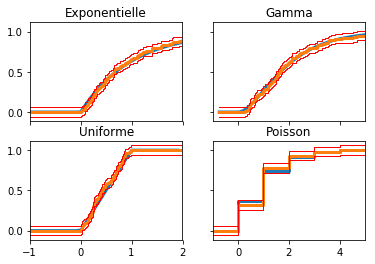

In [17]:
taille = 10**2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0:
        echantillon = stats.expon.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax1
        a.plot(x, stats.expon.cdf(x, loc=0, scale=1))
    if i==1:
        echantillon = stats.gamma.rvs(a=2, loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, a=2, loc=0, scale=1))
    if i==2:
        echantillon = stats.uniform.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x, loc=0, scale=1))
    if i==3:
        echantillon = stats.poisson.rvs(mu=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x, mu=1))
    s, y = ecdf(echantillon)
    a.step(s, y)
    a.set_title(t[i])
    epsilon = (np.std(y))*stats.norm.ppf(0.975,loc=0, scale=1) / ((taille**0.5)) 
    a.step(s,y + epsilon, 'r', linewidth=1.0)
    a.step(s,y - epsilon, 'r', linewidth=1.0)
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])
    

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.2.6.</b> 

J'ai mis à rouge les courbes qui limitent l'interval de confiance bilatéral symétrique de $𝐹_X(x)$ au niveau asymptotique 95%, c'est à dire les courbes dédans lesquelles la probabilité que la vrai fonction y tombe est de 95%. Lorsque N augmente, les courbes deviennent vraiment proches l'une de l'autre, ce qui était attendue en vue du fait que $\widehat \varepsilon_N(x)$ decroît selon $1/\sqrt N$ quand N augmente. Si par contre on diminue la taille d'échantillon, l'écart entre les courbes augmente.

</div>

<h2> III.3. Méthode du rejet </h2>

Soit $Y$ une variable aléatoire absolument continue admettant pour densité $f$ satisfaisant $f(x) = 0$ si $\lvert x \rvert \geq 1$ et $\sup f < \infty$. On génère itérativement des points uniformément répartis sur $[-1,1] \times [0,K]$ avec $K \geq 2\sup f$ jusqu'à avoir généré un point sous la courbe $f$. Sur la figure ci-dessous, on a généré les quatre croix avant de générer le point noir.

![title](rejet.png)



On considère alors l'abscisse du premier point sous la courbe, que l'on note $Z$. Dans le deuxième devoir maison, vous montrerez que
$$ \tag{1} P(Z \leq z) = P(X \leq z \mid U \leq f(X)), \ z \in \mathbb{R}, $$
avec $(X, U)$ uniformément réparti sur $[-1,1] \times [0,K]$.

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.1.</b> Donnez la densité de $(X, U)$ et déduisez de (1) que $Z$ admet $f$ pour densité.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.1.</b> 

X et U étant indépendantes,

$$f_{XU}(x,u) = f_X(x) f_U(u) = \frac{1}{2K} \mathbb{1}(|x| \leq 1) \mathbb{1}(0 \leq u \leq K) $$

Utilisant le résultat démontré au DM1:

$$ F_Z(z) = P(Z \leq z) = P(X \leq z \mid U \leq f(X)) = \frac{ \int_{-\infty}^{z} \int_{-\infty}^{f(X)} \frac{1}{2K} \mathbb{1}(0 \leq u \leq K) \mathbb{1}(|x| \leq 1) du dx  }
                                               {\frac{1}{K} \int_{-\infty}^{f(X)} \mathbb{1}(0 \leq u \leq K) du}
= \int_{-\infty}^{z} \frac{1}{2} \mathbb{1}(|x| \leq 1) dx = \int_{-\infty}^{z} f_X dx = F_X(z)$$

Comme $$ f_Z(z) = \frac{dF_Z(z)}{dz} = \frac{dF_X(z)}{dz} = f_X(z),$$

Alors Z admet f pour densité.
</div>


<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.2.</b> Quelle est la loi du nombre de points rejetés avant d'en accepter un? Précisez la valeur du paramètre de cette loi. En déduire le nombre moyen de simulations nécessaires afin de simuler $Y$ selon cette méthode.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.2.</b> 

À chaque tirage, les loi de tirage de U et de X sont les mêmes (des lois uniformes), et la probabilité d'accepter le point tiré est $p=P(U \leq f_X(X))$. Donc, la loi d'acceptation suivi par les tirages est une loi géometrique de parametre p. Ainsi, si Y est le nombre de points rejetés avant d'en accepter un, on a:

$$ P(Y=y)=(1-p)^{y-1}p $$

Le nombre moyen de tirages nécéssaires pour en accepter une est $1/p$ (l'espérance de la loi géometrique).

</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.3.</b> Ecrivez un script qui implante cette méthode dans le cas où $f$ est la densité normale tronquée, i.e.,
$$ f(x) \propto \exp\left( -\frac{x^2}{2} \right) {\bf 1}(-1 \leq x \leq 1). $$
Vous vérifierez bien que la sortie de votre script admet la bonne loi.</p>

p théorique = 0.25
p empirique = 0.24807


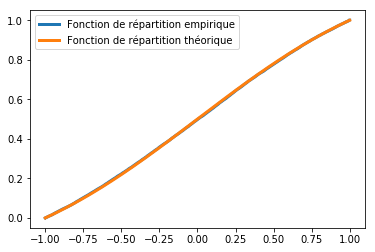

In [7]:
taille_echantillon = 10**5
K = 2
x = np.random.uniform(low = -1, high = 1, size = taille_echantillon)
u = np.random.uniform(low = 0, high = K, size = taille_echantillon)
echantillon=np.zeros(1)
echantillon = x[u <= stats.truncnorm.pdf(x, -1, 1)]
s, y = ecdf(echantillon)
s = s[1:-1]
y = y[1:-1]
plt.step(s, y, label="Fonction de répartition empirique")
plt.plot(s, (stats.truncnorm.cdf(s,-1,1)), label= "Fonction de répartition théorique")
plt.legend()
p=1/(2*K)
print("p théorique =", p)
p_empirique=len(echantillon)/taille_echantillon
print("p empirique =", p_empirique)

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.3.</b> 

On voit bien que la courbe théorique et la courbe empirique sont presque coincidentes, prouvant le bon fonctionnement de la méthode du rejet dans ce cas. On pourrait obtenir des courbes encore plus proches en augmentant la taille d'échantillonage.

</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION III.3.4.</b> A l'aide de la méthode du rejet, écrivez un code qui permet de générer une variable aléatoire de densité $\displaystyle f(x) \propto \lvert x \rvert \exp(\lvert x \rvert^\pi) {\bf 1}(\lvert x \rvert < 1)$. Le code suivant vous permet de calculer la constante de normalisation.</p>

In [28]:
def f_unnor(x):
    return np.abs(x)*np.exp(np.abs(x)**np.pi)
from scipy.integrate import quad
constante = quad(f_unnor, -1, 1)[0]
print(constante)

1.545701318764483


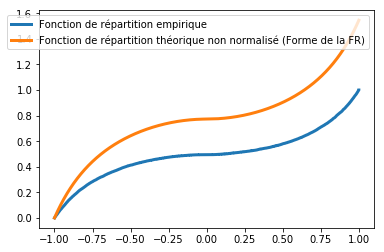

In [27]:
taille_echantillon = 10**5
K = 2*np.exp(1)
x = np.random.uniform(low = -1, high = 1, size = taille_echantillon)
u = np.random.uniform(low = 0, high = K, size = taille_echantillon)
echantillon=np.zeros(1)
echantillon = x[u <= f_unnor(x)]
s, y = ecdf(echantillon)
s = s[1:-1]
y = y[1:-1]
theorie = []
for j in range(len(s)):
    I = quad(f_unnor, -1, s[j])
    theorie.append(I[0])
plt.step(s, y, label="Fonction de répartition empirique")
plt.plot(s, (theorie), label= "Fonction de répartition théorique non normalisé (Forme de la FR)")
plt.legend()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION III.3.4.</b> 

On voit bien que la méthode du rejet nous a permis d'arriver à la forme normalisée correcte de la densité. En effet, on voit que la fonction de répartion obtenue empiriquement ne diffère de la fonction de répartition théorique non normalisée donnée (qui donne la forme de la courbe) que par la constante calculée avant.

</div>